In [39]:
import pandas as pd
from pandas import DatetimeIndex
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from time import time

# Ice Cream Production Data

In [40]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [41]:
production_ice_cream = pd.read_csv('../1_data/ice_cream.csv', parse_dates=[0], index_col=0, date_parser=parser).squeeze("columns") 

In [42]:
production_ice_cream.rename('production', inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [43]:
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [44]:
#just get data from 2010 onwards
start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]

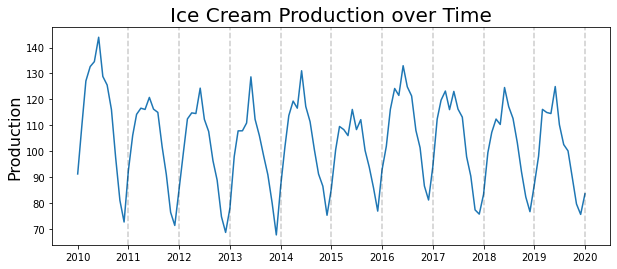

In [45]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)), color='k', linestyle='--', alpha=0.2)

## ACF

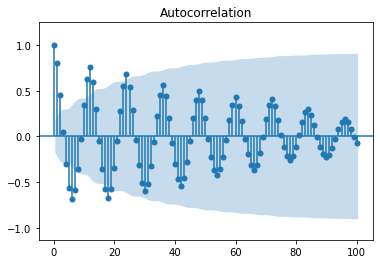

In [46]:
acf_plot = plot_acf(production_ice_cream, lags=100, auto_ylims=True)

## PACF

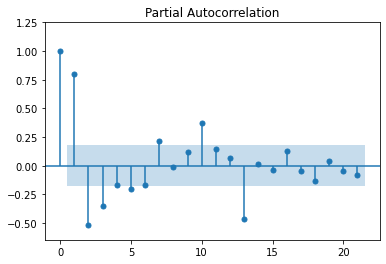

In [47]:
pacf_plot = plot_pacf(production_ice_cream, method='ywm', auto_ylims=True)

## Get training and testing sets

In [48]:
train_end = datetime(2016,12,1)
test_end = datetime(2019,12,1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]

## Fit the AR Model

In [49]:
model = ARIMA(train_data, order=(3,0,0))  #try: order=(3,0,0), order=(7,0,0) 

In [50]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.20699620246887207


In [51]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                   84
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -294.008
Date:                Tue, 30 Aug 2022   AIC                            598.015
Time:                        10:56:06   BIC                            610.169
Sample:                    01-01-2010   HQIC                           602.901
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5071      2.531     40.893      0.000      98.546     108.468
ar.L1          1.0488      0.116      9.046      0.000       0.822       1.276
ar.L2         -0.0532      0.204     -0.260      0.7

In [52]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [53]:
#get predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

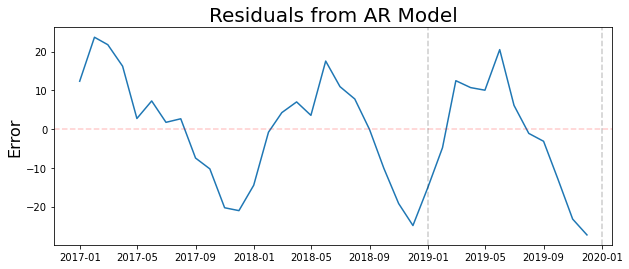

In [54]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)), color='k', linestyle='--', alpha=0.2)

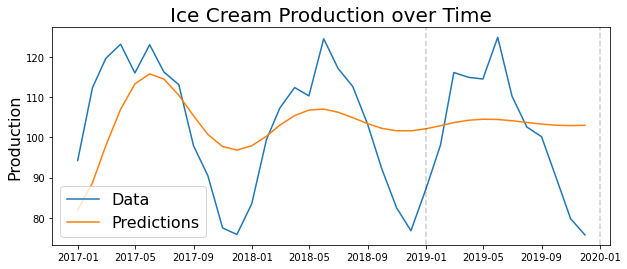

In [55]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)), color='k', linestyle='--', alpha=0.2)

In [56]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.1211


In [57]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 13.890102334146817
